In [0]:
# Databricks-ready PySpark code for dataset: ott_user_behavior_1
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.recommendation import ALS
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

spark = SparkSession.builder.appName("OTT_Analytics").getOrCreate()

# ---------- 1) Load dataset (try Spark table, else CSV fallback) ----------
dataset_name = "ott_user_behavior_1"

try:
    df = spark.table(dataset_name)
    print(f"Loaded Spark table: {dataset_name}")
except Exception as e:
    print(f"Table {dataset_name} not found, trying CSV at /FileStore/tables/{dataset_name}.csv")
    df = spark.read.option("header", "true").option("inferSchema", "true") \
            .csv(f"/FileStore/tables/{dataset_name}.csv")

# quick clean / cast commonly-needed columns
# adjust column names if your schema differs (case-sensitive in Spark)
# Ensure numeric columns are numeric
num_cols = ["age", "avg_watch_time_per_day", "total_watch_time", "watch_duration",
            "completion_rate", "rating_given", "total_sessions_per_week",
            "avg_stream_quality", "network_speed_mbps", "buffering_count",
            "monthly_spend", "peak_watch_hour", "churn_flag"]
for c in num_cols:
    if c in df.columns:
        df = df.withColumn(c, col(c).cast(DoubleType()))

# Fill NA for numeric cols with 0 for safe model training (simple strategy)
numeric_present = [c for c in num_cols if c in df.columns]
df = df.fillna({c: 0.0 for c in numeric_present})

Loaded Spark table: ott_user_behavior_1


In [0]:
from pyspark.sql.functions import col, lit, least, greatest, explode
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.recommendation import ALS

# ✅ Load directly from catalog, not CSV
df = spark.table("workspace.default.ott_user_behavior_1")

display(df.limit(5))

user_id,user_name,age,gender,region,subscription_type,subscription_start_date,subscription_end_date,is_active,device_type,content_id,content_title,genre,content_type,language,release_year,avg_watch_time_per_day,total_watch_time,watch_date,watch_duration,completion_rate,rating_given,liked,recommended_content_ids,last_login_time,total_sessions_per_week,avg_stream_quality,peak_watch_hour,network_speed_mbps,buffering_count,payment_method,monthly_spend,churn_flag,account_creation_date
U10000,Heather Morales,36,Female,Kerala,Standard,2024-06-24,2025-05-31,1,Tablet,C1267,Adaptive full-range secured line,Documentary,Series,Tamil,2015,73.11,5953.69,2025-10-20,163.33,42.18,1.7,0,"C1249, C1476, C1485",10-11-2025 15:35,23,480p,14,51.41,0,UPI,649,0,2023-10-12
U10001,Roy Ritter,22,Female,Maharashtra,Standard,2024-06-24,2025-01-15,1,Tablet,C1368,Open-architected intangible time-frame,Sci-Fi,Movie,Tamil,2017,44.49,3392.53,2025-09-30,29.56,87.77,2.8,0,"C1062, C1300, C1183",06-11-2025 00:40,22,4K,16,64.78,3,UPI,799,0,2023-09-30
U10002,Jamie Johnson,27,Other,Uttar Pradesh,Standard,2024-04-13,2025-01-21,1,Laptop,C1297,Exclusive real-time capacity,Drama,Movie,Japanese,2024,91.23,4349.78,2025-07-03,132.15,42.49,3.3,0,"C1061, C1352, C1303",03-11-2025 03:30,27,1080p,15,98.66,5,Debit Card,649,0,2023-09-04
U10003,Tina Miller,55,Female,Kerala,Premium,2024-09-13,2025-08-21,1,Smart TV,C1283,Intuitive discrete secured line,Drama,Series,English,2017,96.59,5661.75,2025-08-04,145.64,51.4,4.6,1,"C1295, C1285, C1304",01-11-2025 14:00,20,480p,14,69.38,3,Credit Card,199,0,2023-12-20
U10004,Michael Jenkins,27,Male,Tamil Nadu,Basic,2024-06-26,2025-02-23,1,Smart TV,C1062,Realigned explicit Graphical User Interface,Drama,Series,Telugu,2020,140.22,9017.31,2025-09-18,111.85,51.36,4.2,1,"C1112, C1457, C1066",07-11-2025 23:34,7,720p,14,53.15,1,Debit Card,799,0,2024-01-15


content_id,genre,content_title,avg_rating,num_watchers
C1168,Thriller,Stand-alone needs-based flexibility,5.0,1
C1312,Comedy,Object-based object-oriented capacity,5.0,1
C1407,Documentary,Exclusive zero tolerance frame,5.0,1
C1204,Thriller,Exclusive client-driven benchmark,5.0,1
C1217,Action,Phased fault-tolerant forecast,5.0,1
C1255,Comedy,Distributed interactive product,5.0,1
C1459,Romance,Face-to-face modular encryption,5.0,1
C1412,Thriller,Extended clear-thinking functionalities,5.0,1
C1005,Action,Pre-emptive client-server challenge,5.0,1
C1121,Thriller,Assimilated background emulation,5.0,1


/home/spark-60eead6c-942c-4f2d-95d2-ae/.ipykernel/2488/command-8286201603137874-2633767782:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="num_watchers", y="content_title", data=pdf_content, palette="viridis")


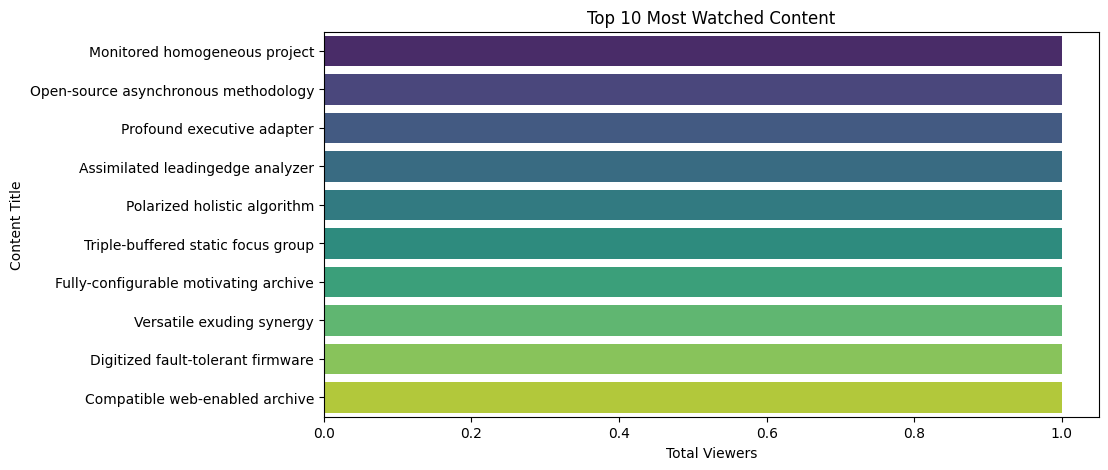

user_id,genre,content_id,content_title,avg_rating,num_watchers
U10000,Documentary,C1132,Front-line 24hour attitude,5.0,1
U10000,Documentary,C1228,Managed 4thgeneration artificial intelligence,5.0,1
U10000,Documentary,C1299,Reverse-engineered secondary open system,5.0,1
U10000,Documentary,C1407,Exclusive zero tolerance frame,5.0,1
U10000,Documentary,C1014,Digitized logistical portal,5.0,1
U10000,Documentary,C1416,Sharable multimedia standardization,4.9,1
U10000,Documentary,C1388,Distributed motivating knowledge user,4.9,1
U10000,Documentary,C1459,Focused didactic superstructure,4.9,1
U10000,Documentary,C1273,Quality-focused exuding functionalities,4.9,1
U10000,Documentary,C1337,Phased full-range function,4.9,1


Databricks visualization. Run in Databricks to view.

In [0]:
# ---------- Use Case 2: Content Recommendation System ----------

from pyspark.sql.functions import col, avg, count, row_number, desc
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Content-level metrics ---
if "content_id" in df.columns and "rating_given" in df.columns:
    content_stats = (
        df.groupBy("content_id", "genre", "content_title")
        .agg(
            round(avg("rating_given"), 2).alias("avg_rating"),
            count("user_id").alias("num_watchers")
        )
        .orderBy(desc("avg_rating"), desc("num_watchers"))
    )
    display(content_stats.limit(20))

    # --- Visualization: Top 10 Most Watched Titles ---
    pdf_content = content_stats.toPandas().sort_values("num_watchers", ascending=False).head(10)
    plt.figure(figsize=(10,5))
    sns.barplot(x="num_watchers", y="content_title", data=pdf_content, palette="viridis")
    plt.title("Top 10 Most Watched Content")
    plt.xlabel("Total Viewers")
    plt.ylabel("Content Title")
    plt.show()
else:
    print("⚠️ Required columns missing for recommendation system.")

# --- Step 2: User preference by genre ---
if "user_id" in df.columns and "genre" in df.columns:
    user_genre_pref = (
        df.groupBy("user_id", "genre")
        .count()
        .withColumnRenamed("count", "watch_count")
    )

    # pick top genre per user
    w = Window.partitionBy("user_id").orderBy(desc("watch_count"))
    user_top_genre = (
        user_genre_pref.withColumn("rank", row_number().over(w))
        .filter(col("rank") == 1)
        .drop("rank")
    )

    # --- Step 3: Recommend top content in user's preferred genre ---
    recommendations = (
        user_top_genre.join(content_stats, on="genre", how="inner")
        .select("user_id", "genre", "content_id", "content_title", "avg_rating", "num_watchers")
        .orderBy("user_id", desc("avg_rating"))
    )

    display(recommendations.limit(50))

else:
    print("⚠️ Missing columns 'user_id' or 'genre' for user preference analysis.")